#  Planetly Data Science Takehome Test



---

##Estimated Time : 2 - 4 hours
#This Excercise uses pyspark dataframes to Manipulate and aggegrate data. 

>  Please make sure that all dependencies are loaded

>  Please use the [Google Colab notebook](https://colab.research.google.com/drive/1XZ_EM5xk4I87tUtjjUl5enSHEyJvsyq8?usp=sharing) to skip installing Dependencies


If you are using Colab, Please Save the CSV files in a folder Planetly inside your GDrive

>GlobalLandTemperaturesByCity.csv 

>GlobalLandTemperaturesByCountry.csv

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##If used as a Notebook, Please pass the entire path to the files.

In [2]:
!pip install pyspark

In [3]:
import os
import datetime
import numpy as np
import pandas as pd
from pyspark.sql import *
import plotly.express as px
import pyspark.sql.functions as F

###Creating a Pandas Class to read data and return dataframe so that the same code can be reused for 2 different datasets

In [4]:
class pandasses:
  def __init__(self, SeSname,data,path):
      start_time = datetime.datetime.now()
      self.name = str(SeSname)
      self.data = data
      str1 = path + self.data
      print(str1)
      try:
        self.pandas_df = pd.read_csv(str1)        
        print('Data Read')
        print(self.pandas_df)
      except:
        print('Session Start failed')
      end_time = datetime.datetime.now()
      print("Time taken to read:", (end_time-start_time))

  def return_data_parsed_dates(self,col_name):
    start_time = datetime.datetime.now()
    self.name = self.pandas_df.copy()
    self.name["dt"] = self.name["dt"].astype('datetime64[ns]')
    try:
      col_name = col_name.split(",")
    except:
      L= []
      col_name = L.append(col_name)
    col_name.append("dt")

    q1 = self.name[col_name]
    q1 = q1.sort_values('dt')
    end_time =datetime.datetime.now()
    print("Time taken to parse:", (end_time-start_time))
    return q1

###Creating a session named P2 for the data GlobalLandTemperaturesByCity
###Additional sessions can be created for different data sources

In [5]:
Path_to_folder = "/content/drive/MyDrive/Planetly/"

p2 =  pandasses("ROS","GlobalLandTemperaturesByCity.csv",Path_to_folder)
df = p2.return_data_parsed_dates('AverageTemperature,City')
df

/content/drive/MyDrive/Planetly/GlobalLandTemperaturesByCity.csv
Data Read
                 dt  AverageTemperature  ...  Latitude Longitude
0        1743-11-01               6.068  ...    57.05N    10.33E
1        1743-12-01                 NaN  ...    57.05N    10.33E
2        1744-01-01                 NaN  ...    57.05N    10.33E
3        1744-02-01                 NaN  ...    57.05N    10.33E
4        1744-03-01                 NaN  ...    57.05N    10.33E
...             ...                 ...  ...       ...       ...
8599207  2013-05-01              11.464  ...    52.24N     5.26E
8599208  2013-06-01              15.043  ...    52.24N     5.26E
8599209  2013-07-01              18.775  ...    52.24N     5.26E
8599210  2013-08-01              18.025  ...    52.24N     5.26E
8599211  2013-09-01                 NaN  ...    52.24N     5.26E

[8599212 rows x 7 columns]
Time taken to read: 0:00:25.029909
Time taken to parse: 0:00:07.817693


,AverageTemperature,City,dt
0,6.068,Århus,1743-11-01
5910257,5.044,Pleven,1743-11-01
5913496,4.635,Plock,1743-11-01
5916735,2.872,Ploiesti,1743-11-01
5919974,4.528,Plovdiv,1743-11-01
...,...,...,...
7330815,NaN,Tabriz,2013-09-01
2684940,NaN,Guangyuan,2013-09-01
2682622,NaN,Guangshui,2013-09-01
2707002,21.815,Guatemala City,2013-09-01


 ### <font color='D95B5B'> Pandas began to crash beyond this point on certain test entries and sample manipulations. We had to move to Spark Dataframes</font>


In [6]:
df['dt'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                 8599212
unique                   3239
top       1939-11-01 00:00:00
freq                     3510
first     1743-11-01 00:00:00
last      2013-09-01 00:00:00
Name: dt, dtype: object

#<font color='D95B5B'> Design Choice : Pyspark Vs Pandas </font>

> 1) Pandas data frame is not distributed & Spark's DataFrame is distributed. -> Hence you won't get the benefit of parallel processing in Pandas DataFrame & speed of processing in Pandas DataFrame will be less beyond a certain volume of data.

> 2) Spark DataFrame assures you fault tolerance (It's resilient) & pandas DataFrame does not assure it. 
-> Hence if your data processing got interrupted/failed in between processing then spark can regenerate the failed result set from lineage (from DAG) . Fault tolerance is not supported in Pandas. You need to implement your own framework to assure it.

> 3) Pyspark.SQL supports native HIVE SQL queries which are much faster in pipelining and manupalition of Data


##<font color='5BD2D9'> Creating a class instance which actually reads the data into a spark dataframe and has additional functions to parse dates and allow queries on the parsed data

In [7]:
class sparkses:
    def __init__(self, SeSname,path_to_data):      # initializing the session and reading the data
      start_time = datetime.datetime.now()
      self.name = str(SeSname)
      self.path_to_data = path_to_data
      self.spark = SparkSession.builder.appName(self.name).config("spark.some.config.option", "some-value").getOrCreate()
      print('Session Started')
      str1 = path_to_data 
      try:
        self.spark_df = self.spark.read.load(str1,format="csv", sep=",", inferSchema="true", header="true")        
        print('Data Read')
        print(self.spark_df.printSchema())
      except:
        print('Session Start failed')
      end_time = datetime.datetime.now()
      print("Time taken to read:", (end_time-start_time))

    def return_data_parsed_dates(self,col_name):  # parsing text into a date format
      start_time = datetime.datetime.now()
      self.spark_df.createOrReplaceTempView(self.name)
      q1 = "SELECT TO_DATE(CAST(UNIX_TIMESTAMP(dt, 'yyyy-MM-dd') AS TIMESTAMP)) AS dt, \
      {columns} FROM {tbl_name} where dt is not null  ORDER BY dt desc".format(columns = col_name, tbl_name=self.name)
      print(q1)
      sqlDF = self.spark.sql(q1)
      print(sqlDF) 
      sqlDF.show()
      return sqlDF
      end_time = datetime.datetime.now()
      print("Time taken to parse:", (end_time-start_time))
    
    def run_sql(self,Query,data): # Allowing Sql Queries
      data.createOrReplaceTempView(self.name)
      q1 = Query.format(tbl_name=self.name)
      print(q1)
      sqlDF = self.spark.sql(q1)
      sqlDF.show(truncate = False)
      return sqlDF







##Starting a session named City for exploring GlobalLandTemperaturesByCity.csv 

In [8]:
path_to_data = "/content/drive/MyDrive/Planetly/GlobalLandTemperaturesByCity.csv"
name = "CITY"
p1 = sparkses(name,path_to_data)

Session Started
Data Read
root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)

None
Time taken to read: 0:00:37.453667


##Selecting City Average Temperature and parsed date into a dataframe for vizualization.
##Null Labels in Dates and city can be dropped as they cannot be extrapolated

In [9]:
d = p1.return_data_parsed_dates('AverageTemperature,AverageTemperatureUncertainty,City')

SELECT TO_DATE(CAST(UNIX_TIMESTAMP(dt, 'yyyy-MM-dd') AS TIMESTAMP)) AS dt,       AverageTemperature,AverageTemperatureUncertainty,City FROM CITY where dt is not null  ORDER BY dt desc
DataFrame[dt: date, AverageTemperature: double, AverageTemperatureUncertainty: double, City: string]
+----------+------------------+-----------------------------+-----------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|       City|
+----------+------------------+-----------------------------+-----------+
|2013-09-01|              null|                         null|      Eluru|
|2013-09-01|              null|                         null| Esmeraldas|
|2013-09-01|              null|                         null|       Embu|
|2013-09-01|13.687999999999999|           1.4880000000000002|   Edmonton|
|2013-09-01|              null|                         null|      Emmen|
|2013-09-01|              null|                         null|      Ejido|
|2013-09-01|              null|                  

###Checking number of null values in the dataset

In [10]:
d2 = p1.run_sql(Query = "SELECT * FROM (SELECT COUNT(City) as Cnt,City FROM {tbl_name} where AverageTemperature is null GROUP BY City ) where cnt > 0 order by cnt Desc",data = d)


SELECT * FROM (SELECT COUNT(City) as Cnt,City FROM CITY where AverageTemperature is null GROUP BY City ) where cnt > 0 order by cnt Desc
+----+----------------+
|Cnt |City            |
+----+----------------+
|1039|Saint Denis     |
|1039|Port Louis      |
|1036|Fianarantsoa    |
|958 |Antsirabe       |
|958 |Mahajanga       |
|958 |Antananarivo    |
|958 |Nacala          |
|958 |Toamasina       |
|921 |Toliary         |
|772 |Depok           |
|772 |Taman           |
|627 |Aurora          |
|584 |New Orleans     |
|584 |Metairie        |
|584 |Baton Rouge     |
|560 |Shreveport      |
|547 |Oklahoma City   |
|540 |Fort Collins    |
|529 |Lakewood        |
|529 |Colorado Springs|
+----+----------------+
only showing top 20 rows



###The Data is at a monthly average, or is one reading  per month. We can extrapolate by Replacing null AverageTemperature with the quaterly average.

In [11]:
d3 = p1.run_sql(Query = "SELECT dt , CONCAT(YEAR(dt),'-',QUARTER(dt)) as YEAR_QUARTER ,City, coalesce (AverageTemperature , avg(AverageTemperature) over (PARTITION BY City, CONCAT(YEAR(dt),'-',QUARTER(dt))))  as AverageTemperature,AverageTemperatureUncertainty  FROM {tbl_name} ORDER BY dt desc",data = d)

SELECT dt , CONCAT(YEAR(dt),'-',QUARTER(dt)) as YEAR_QUARTER ,City, coalesce (AverageTemperature , avg(AverageTemperature) over (PARTITION BY City, CONCAT(YEAR(dt),'-',QUARTER(dt))))  as AverageTemperature,AverageTemperatureUncertainty  FROM CITY ORDER BY dt desc
+----------+------------+--------------+------------------+-----------------------------+
|dt        |YEAR_QUARTER|City          |AverageTemperature|AverageTemperatureUncertainty|
+----------+------------+--------------+------------------+-----------------------------+
|2013-09-01|2013-3      |Bhagalpur     |29.899            |null                         |
|2013-09-01|2013-3      |Benghazi      |25.160000000000004|null                         |
|2013-09-01|2013-3      |Ekibastuz     |19.7835           |null                         |
|2013-09-01|2013-3      |Hanzhong      |25.3615           |null                         |
|2013-09-01|2013-3      |Netanya       |26.8085           |null                         |
|2013-09-01|2013

In [12]:
d4 = p1.run_sql(Query = "SELECT * FROM (SELECT COUNT(City) as Cnt,City FROM {tbl_name} where AverageTemperature is null GROUP BY City ) where cnt > 0 order by cnt Desc ",data = d3)

SELECT * FROM (SELECT COUNT(City) as Cnt,City FROM CITY where AverageTemperature is null GROUP BY City ) where cnt > 0 order by cnt Desc 
+----+----------------+
|Cnt |City            |
+----+----------------+
|1029|Port Louis      |
|1029|Saint Denis     |
|1026|Fianarantsoa    |
|945 |Nacala          |
|945 |Antsirabe       |
|945 |Antananarivo    |
|945 |Toamasina       |
|945 |Mahajanga       |
|909 |Toliary         |
|756 |Depok           |
|756 |Taman           |
|570 |New Orleans     |
|570 |Metairie        |
|570 |Baton Rouge     |
|543 |Shreveport      |
|531 |Oklahoma City   |
|522 |Lakewood        |
|522 |Colorado Springs|
|522 |Westminster     |
|522 |Norman          |
+----+----------------+
only showing top 20 rows



SUMMARY OF OUTPUT 

---


*   d  = Raw Dataset with formatted Dates
*   d2 = Null Count 
*   d3 = Extrapolated Dataset with nulls replaced by quarter average
*   d4 = Null Count Extrapolated Dataset





#EDA TASK 2.
###Write a function which returns N entries of cities which have the highest
###variability in AverageTemperature in a specified time range.



In [13]:
#only provide table with Parsed dates

def return_varience(start_date,End_date,tbl_name,session , N):
  Q = "SELECT Distinct City, variance(AverageTemperature) OVER (PARTITION BY City) as Variance FROM {tbl_name} where City like '%%' and dt >= TO_DATE(CAST(UNIX_TIMESTAMP('{start_date}', 'yyyy-MM-dd') AS TIMESTAMP)) and dt <= TO_DATE(CAST(UNIX_TIMESTAMP('{End_date}', 'yyyy-MM-dd') AS TIMESTAMP)) Order by Variance desc LIMIT {N}".format(start_date = start_date, End_date = End_date,tbl_name = '{tbl_name}',N=N )
  sqlDF = session.run_sql(Query = Q ,data = tbl_name)
  sqlDF.show(truncate = False)
  return sqlDF

##Returng varience with Extrapolated Data

In [14]:
start_date = '2013-09-01' # YY-MM-DD
End_date = '2016-09-01'
N= 5
return_varience(start_date,End_date,d3,p1,N)

SELECT Distinct City, variance(AverageTemperature) OVER (PARTITION BY City) as Variance FROM CITY where City like '%%' and dt >= TO_DATE(CAST(UNIX_TIMESTAMP('2013-09-01', 'yyyy-MM-dd') AS TIMESTAMP)) and dt <= TO_DATE(CAST(UNIX_TIMESTAMP('2016-09-01', 'yyyy-MM-dd') AS TIMESTAMP)) Order by Variance desc LIMIT 5
+-----------+-----------------+
|City       |Variance         |
+-----------+-----------------+
|Kingston   |98.33628800000011|
|La Paz     |50.21222472      |
|Peoria     |38.01919999999999|
|Arlington  |34.8028245       |
|Santa Clara|33.194952        |
+-----------+-----------------+

+-----------+-----------------+
|City       |Variance         |
+-----------+-----------------+
|Kingston   |98.33628800000011|
|La Paz     |50.21222472      |
|Peoria     |38.01919999999999|
|Arlington  |34.8028245       |
|Santa Clara|33.194952        |
+-----------+-----------------+



DataFrame[City: string, Variance: double]

##Returng varience without Extrapolated Data (Raw Dataset)

In [15]:
start_date = '2013-09-01' # YY-MM-DD
End_date = '2016-09-01'
return_varience(start_date,End_date,d,p1,N)

SELECT Distinct City, variance(AverageTemperature) OVER (PARTITION BY City) as Variance FROM CITY where City like '%%' and dt >= TO_DATE(CAST(UNIX_TIMESTAMP('2013-09-01', 'yyyy-MM-dd') AS TIMESTAMP)) and dt <= TO_DATE(CAST(UNIX_TIMESTAMP('2016-09-01', 'yyyy-MM-dd') AS TIMESTAMP)) Order by Variance desc LIMIT 5
+-----------+-----------------+
|City       |Variance         |
+-----------+-----------------+
|Kingston   |98.33628800000011|
|León       |43.78608200000001|
|Peoria     |38.01919999999999|
|Arlington  |34.8028245       |
|Santa Clara|33.194952        |
+-----------+-----------------+

+-----------+-----------------+
|City       |Variance         |
+-----------+-----------------+
|Kingston   |98.33628800000011|
|León       |43.78608200000001|
|Peoria     |38.01919999999999|
|Arlington  |34.8028245       |
|Santa Clara|33.194952        |
+-----------+-----------------+



DataFrame[City: string, Variance: double]

##EDA TASK 3. 

###Plot the temperature development (and uncertainty) over time (aggregate as you see fit) of the top 4 entries of your function for a given time period and save the plot as a .png file.

##setting parameters

In [16]:
start_date = '2010-09-01' # YY-MM-DD    Getting the first 4 entries for raw data
End_date = '2012-09-01'
N = 4 
List  = False  # We can also pass a list of cities like ['A','B'] we have to Pass N as False
data = d

In [17]:
def plot_N(start_date,End_date,N,List,data,session):
  if N:
    cont = return_varience(start_date,End_date,data,session,N)   
    L  = cont.select("city").rdd.flatMap(lambda x: x).collect()
  elif List:
    L = List   
  d = data.filter(F.col("city").isin(L))
  Q = "SELECT Distinct dt,City, AverageTemperature,AverageTemperatureUncertainty FROM {tbl_name} where dt >= TO_DATE(CAST(UNIX_TIMESTAMP('{start_date}', 'yyyy-MM-dd') AS TIMESTAMP)) and \
               dt <= TO_DATE(CAST(UNIX_TIMESTAMP('{End_date}', 'yyyy-MM-dd') AS TIMESTAMP)) Order by dt".format(start_date = start_date, End_date = End_date,tbl_name = '{tbl_name}' )

  dx = session.run_sql(Query = Q,data = d).toPandas()
  fig1 = px.line(dx, x="dt", y="AverageTemperature", color='City',hover_name="AverageTemperatureUncertainty")
  fig1.show()


In [18]:
plot_N(start_date,End_date,N,List,data,p1)

SELECT Distinct City, variance(AverageTemperature) OVER (PARTITION BY City) as Variance FROM CITY where City like '%%' and dt >= TO_DATE(CAST(UNIX_TIMESTAMP('2010-09-01', 'yyyy-MM-dd') AS TIMESTAMP)) and dt <= TO_DATE(CAST(UNIX_TIMESTAMP('2012-09-01', 'yyyy-MM-dd') AS TIMESTAMP)) Order by Variance desc LIMIT 4
+-------+-----------------+
|City   |Variance         |
+-------+-----------------+
|Hailar |300.16762725     |
|Yakeshi|300.16762725     |
|Kyzyl  |294.8808625566666|
|Nehe   |279.7880595766667|
+-------+-----------------+

+-------+-----------------+
|City   |Variance         |
+-------+-----------------+
|Hailar |300.16762725     |
|Yakeshi|300.16762725     |
|Kyzyl  |294.8808625566666|
|Nehe   |279.7880595766667|
+-------+-----------------+

SELECT Distinct dt,City, AverageTemperature,AverageTemperatureUncertainty FROM CITY where dt >= TO_DATE(CAST(UNIX_TIMESTAMP('2010-09-01', 'yyyy-MM-dd') AS TIMESTAMP)) and                dt <= TO_DATE(CAST(UNIX_TIMESTAMP('2012-09-01', 'yyy

##I skipped the save png part as Average temperature uncertainty is a hover value

In [19]:
plot_N(start_date,End_date,False,['Berlin','Delhi'],d,p1)

SELECT Distinct dt,City, AverageTemperature,AverageTemperatureUncertainty FROM CITY where dt >= TO_DATE(CAST(UNIX_TIMESTAMP('2010-09-01', 'yyyy-MM-dd') AS TIMESTAMP)) and                dt <= TO_DATE(CAST(UNIX_TIMESTAMP('2012-09-01', 'yyyy-MM-dd') AS TIMESTAMP)) Order by dt
+----------+------+-------------------+-----------------------------+
|dt        |City  |AverageTemperature |AverageTemperatureUncertainty|
+----------+------+-------------------+-----------------------------+
|2010-09-01|Berlin|13.558             |0.157                        |
|2010-09-01|Delhi |28.612             |0.733                        |
|2010-10-01|Berlin|8.339              |0.139                        |
|2010-10-01|Delhi |27.256             |0.475                        |
|2010-11-01|Delhi |21.756999999999998 |0.314                        |
|2010-11-01|Berlin|5.2829999999999995 |0.175                        |
|2010-12-01|Delhi |15.393             |0.6509999999999999           |
|2010-12-01|Berlin|-4.412

#EDA TASK 1

Which country has the most severe overall temperature change from decade to
decade? Please elaborate on how you interpret severe change and decade to
decade.

In [22]:
path_to_data = "/content/drive/MyDrive/Planetly/GlobalLandTemperaturesByCountry.csv"   #starting a new spark session with New Data
name = "Country"
C1 = sparkses(name,path_to_data)

Session Started
Data Read
root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- Country: string (nullable = true)

None
Time taken to read: 0:00:02.528349


###Viewing Raw and Parsed Data

In [23]:
d = C1.return_data_parsed_dates( 'AverageTemperature, AverageTemperatureUncertainty, Country')

SELECT TO_DATE(CAST(UNIX_TIMESTAMP(dt, 'yyyy-MM-dd') AS TIMESTAMP)) AS dt,       AverageTemperature, AverageTemperatureUncertainty, Country FROM Country where dt is not null  ORDER BY dt desc
DataFrame[dt: date, AverageTemperature: double, AverageTemperatureUncertainty: double, Country: string]
+----------+------------------+-----------------------------+--------------------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|             Country|
+----------+------------------+-----------------------------+--------------------+
|2013-09-01|              null|                         null|              Norway|
|2013-09-01|              null|                         null|    Saint Barthélemy|
|2013-09-01|              null|                         null|             Oceania|
|2013-09-01|              null|                         null|            Mongolia|
|2013-09-01|              null|                         null|                Oman|
|2013-09-01|              null|         

###Checking the number of Nulls

In [24]:
d2 = C1.run_sql(Query = "SELECT * FROM (SELECT COUNT(Country) as Cnt,Country FROM {tbl_name} where AverageTemperature is null GROUP BY Country ) where cnt > 0 order by cnt desc",data = d)

SELECT * FROM (SELECT COUNT(Country) as Cnt,Country FROM Country where AverageTemperature is null GROUP BY Country ) where cnt > 0 order by cnt desc
+----+----------------+
|Cnt |Country         |
+----+----------------+
|1039|Reunion         |
|1039|Mauritius       |
|958 |Comoros         |
|958 |Seychelles      |
|958 |Mayotte         |
|958 |Madagascar      |
|764 |Antarctica      |
|585 |Niger           |
|572 |Bahamas         |
|459 |United States   |
|459 |North America   |
|437 |Canada          |
|386 |Indonesia       |
|386 |Christmas Island|
|370 |Tanzania        |
|332 |Baker Island    |
|316 |Oman            |
|310 |Peru            |
|305 |Malawi          |
|304 |Pakistan        |
+----+----------------+
only showing top 20 rows



###Replacing Null by Quarterly Average

In [25]:
d3 = C1.run_sql(Query = "SELECT dt , CONCAT(YEAR(dt),'-',QUARTER(dt)) as QUARTER_YEAR ,Country, coalesce (AverageTemperature , avg(AverageTemperature) over (PARTITION BY Country, CONCAT(QUARTER(dt),'-',weekofyear(dt))))  as AverageTemperature  FROM {tbl_name}  ORDER BY dt desc",data = d)

SELECT dt , CONCAT(YEAR(dt),'-',QUARTER(dt)) as QUARTER_YEAR ,Country, coalesce (AverageTemperature , avg(AverageTemperature) over (PARTITION BY Country, CONCAT(QUARTER(dt),'-',weekofyear(dt))))  as AverageTemperature  FROM Country  ORDER BY dt desc
+----------+------------+-------------------------+------------------+
|dt        |QUARTER_YEAR|Country                  |AverageTemperature|
+----------+------------+-------------------------+------------------+
|2013-09-01|2013-3      |Canada                   |7.922000000000001 |
|2013-09-01|2013-3      |Gaza Strip               |25.131582733812948|
|2013-09-01|2013-3      |Asia                     |14.96078358208955 |
|2013-09-01|2013-3      |Croatia                  |17.03539887640449 |
|2013-09-01|2013-3      |China                    |14.075682539682543|
|2013-09-01|2013-3      |British Virgin Islands   |28.991            |
|2013-09-01|2013-3      |Saint Pierre And Miquelon|13.745            |
|2013-09-01|2013-3      |Syria          

In [26]:
d2 = C1.run_sql(Query = "SELECT * FROM (SELECT COUNT(Country) as Cnt,Country FROM {tbl_name} where AverageTemperature is null GROUP BY Country ) where cnt > 0 order by cnt desc",data = d3)

SELECT * FROM (SELECT COUNT(Country) as Cnt,Country FROM Country where AverageTemperature is null GROUP BY Country ) where cnt > 0 order by cnt desc
+---+----------+
|Cnt|Country   |
+---+----------+
|764|Antarctica|
+---+----------+



###Creating an Aggegration by Decade

In [27]:
d2x = C1.run_sql(Query = "SELECT dt , CONCAT(FLOOR(YEAR(dt)/10)*10,'-',(FLOOR(YEAR(dt)/10)*10)+9) as Decade,Country,AverageTemperature FROM {tbl_name} ",data = d3)

SELECT dt , CONCAT(FLOOR(YEAR(dt)/10)*10,'-',(FLOOR(YEAR(dt)/10)*10)+9) as Decade,Country,AverageTemperature FROM Country 
+----------+---------+-------------------------+------------------+
|dt        |Decade   |Country                  |AverageTemperature|
+----------+---------+-------------------------+------------------+
|2013-09-01|2010-2019|Saint Pierre And Miquelon|13.745            |
|2013-09-01|2010-2019|Cyprus                   |24.61871710526316 |
|2013-09-01|2010-2019|Oceania                  |19.278499999999998|
|2013-09-01|2010-2019|Nigeria                  |25.932597938144315|
|2013-09-01|2010-2019|China                    |14.075682539682543|
|2013-09-01|2010-2019|Gaza Strip               |25.131582733812948|
|2013-09-01|2010-2019|Kazakhstan               |14.322419117647062|
|2013-09-01|2010-2019|Jordan                   |25.861503649635033|
|2013-09-01|2010-2019|Syria                    |25.368300000000012|
|2013-09-01|2010-2019|Israel                   |25.3327985611

In [28]:
d3 = C1.run_sql(Query = "SELECT Distinct Country,Decade, \
 avg(AverageTemperature) over (PARTITION BY Country,Decade)  as AverageTemperature \
FROM {tbl_name} order by Country, Decade desc ",data = d2x)

SELECT Distinct Country,Decade,  avg(AverageTemperature) over (PARTITION BY Country,Decade)  as AverageTemperature FROM Country order by Country, Decade desc 
+-----------+---------+------------------+
|Country    |Decade   |AverageTemperature|
+-----------+---------+------------------+
|Afghanistan|2010-2019|15.610839402427635|
|Afghanistan|2000-2009|15.365650000000006|
|Afghanistan|1990-1999|14.73245833333333 |
|Afghanistan|1980-1989|14.59518333333333 |
|Afghanistan|1970-1979|14.035983333333338|
|Afghanistan|1960-1969|13.961283333333325|
|Afghanistan|1950-1959|14.000891666666663|
|Afghanistan|1940-1949|14.386883333333332|
|Afghanistan|1930-1939|13.691550000000005|
|Afghanistan|1920-1929|13.706791666666671|
|Afghanistan|1910-1919|13.819850000000002|
|Afghanistan|1900-1909|13.718941666666673|
|Afghanistan|1890-1899|13.742666666666668|
|Afghanistan|1880-1889|13.673099999999998|
|Afghanistan|1870-1879|13.845849999999993|
|Afghanistan|1860-1869|13.477966666666669|
|Afghanistan|1850-1859|1

In [29]:
d4 = C1.run_sql(Query = "SELECT Country,Decade,AverageTemperature, \
 AverageTemperature -lag(AverageTemperature,-1, null)  over (PARTITION BY Country order by Decade desc)  as Delta \
FROM {tbl_name} order by Country, Decade desc ",data = d3)

SELECT Country,Decade,AverageTemperature,  AverageTemperature -lag(AverageTemperature,-1, null)  over (PARTITION BY Country order by Decade desc)  as Delta FROM Country order by Country, Decade desc 
+-----------+---------+------------------+---------------------+
|Country    |Decade   |AverageTemperature|Delta                |
+-----------+---------+------------------+---------------------+
|Afghanistan|2010-2019|15.610839402427635|0.24518940242762888  |
|Afghanistan|2000-2009|15.365650000000006|0.6331916666666757   |
|Afghanistan|1990-1999|14.73245833333333 |0.1372750000000007   |
|Afghanistan|1980-1989|14.59518333333333 |0.5591999999999917   |
|Afghanistan|1970-1979|14.035983333333338|0.07470000000001242  |
|Afghanistan|1960-1969|13.961283333333325|-0.03960833333333724 |
|Afghanistan|1950-1959|14.000891666666663|-0.3859916666666692  |
|Afghanistan|1940-1949|14.386883333333332|0.6953333333333269   |
|Afghanistan|1930-1939|13.691550000000005|-0.015241666666666376|
|Afghanistan|1920-19

##Plotting Values


In [30]:
d5 = d4.toPandas().drop_duplicates()
d5
fig = px.line(d5, x="Decade", y="Delta", color='Country')
fig.show()

###The highest rise of temperature seems to be for Canada. 

#CONCLUSION

### Due to the size of the dataset, EDA was slow and Additional Analysis was not fiesable. 
### When provided with Additional computational resources and budget, all the questions in the Task can be answered.


END of EDA
---



#1. Build a predictive model 

Forecasts the AverageTemperature of the 4 cities
from the previous task until and including 2013-12-01.

Additionally focus on the
following questions:

1.   Which preprocessing did you perform and why?
2.   Are there any variables or additional data sources you could use?
3.   Which methods/tools would you look into if given more time?
4.   Any results you came across worth mentioning/interpreting? 
5.   How satisfied and confident are you with the resulting model?


In [32]:
#preparing the data
path_to_data = "/content/drive/MyDrive/Planetly/GlobalLandTemperaturesByCity.csv"
name = "CITY_ML"
p3 = sparkses(name,path_to_data)  #start spark session 
print("Parsing Dates")
d = p3.return_data_parsed_dates('AverageTemperature,AverageTemperatureUncertainty,City') #parse Dates
print("Parsed Dates")
print("Preprocessing Data")
d3 = p3.run_sql(Query = "SELECT dt , CONCAT(YEAR(dt),'-',QUARTER(dt)) as YEAR_QUARTER ,City, \
coalesce (AverageTemperature , avg(AverageTemperature) over (PARTITION BY City, CONCAT(YEAR(dt),'-',QUARTER(dt))))  as AverageTemperature,\
AverageTemperatureUncertainty  FROM {tbl_name} ORDER BY dt desc",data = d)   #extrapolate  (preprocessing did you perform and why)
print("Replaced Nulls with Quartely Average")
start_date = '1910-09-01' # YY-MM-DD Date for varience
End_date = '2013-12-01' # YY-MM-DD
N= 4
print("Getting top 4 cities with most Variance")     
cont = return_varience(start_date,End_date,d3,p3,N)   #getting cities
L  = cont.select("city").rdd.flatMap(lambda x: x).collect()
print("Filtering Data for the cities") 
print(L)
d = d3.filter(F.col("city").isin(L[0]))
Q = "SELECT Distinct dt,City, AverageTemperature,AverageTemperatureUncertainty FROM {tbl_name} where dt >= TO_DATE(CAST(UNIX_TIMESTAMP('{start_date}', 'yyyy-MM-dd') AS TIMESTAMP)) and \
               dt <= TO_DATE(CAST(UNIX_TIMESTAMP('{End_date}', 'yyyy-MM-dd') AS TIMESTAMP)) Order by dt".format(start_date =start_date, End_date = End_date,tbl_name = '{tbl_name}' )

dx = p3.run_sql(Query = Q,data = d)




Session Started
Data Read
root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)

None
Time taken to read: 0:00:19.860160
Parsing Dates
SELECT TO_DATE(CAST(UNIX_TIMESTAMP(dt, 'yyyy-MM-dd') AS TIMESTAMP)) AS dt,       AverageTemperature,AverageTemperatureUncertainty,City FROM CITY_ML where dt is not null  ORDER BY dt desc
DataFrame[dt: date, AverageTemperature: double, AverageTemperatureUncertainty: double, City: string]
+----------+------------------+-----------------------------+-----------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|       City|
+----------+------------------+-----------------------------+-----------+
|2013-09-01|            15.252|                        1.056| Abbotsford|
|2013-09-01|              nul

##Since the Df was crashing due to insufficent memory resources, The data is filtered only to one City with the Highest average varation

In [33]:
print("Returning data as a Pandas Df") 
DF = dx.toPandas()
DF

Returning data as a Pandas Df


,dt,City,AverageTemperature,AverageTemperatureUncertainty
0,1910-09-01,Heihe,10.780,0.322
1,1910-10-01,Heihe,2.419,0.568
2,1910-11-01,Heihe,-12.144,0.678
3,1910-12-01,Heihe,-26.688,1.425
4,1911-01-01,Heihe,-28.383,2.272
...,...,...,...,...
1232,2013-05-01,Heihe,14.134,0.254
1233,2013-06-01,Heihe,19.052,0.310
1234,2013-07-01,Heihe,21.046,0.680
1235,2013-08-01,Heihe,18.824,0.394


#Forecast Average Temperatures Sales With the[ Prophet](https://facebook.github.io/prophet/docs/quick_start.html)


Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

(1237, 4)


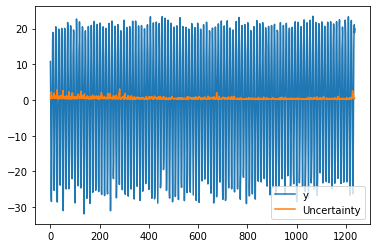

In [38]:
# check prophet version
#!pip install fbprophet
from fbprophet import Prophet
print(DF.shape)
#Data Prep
data = DF
data.columns = ['ds',	'City',	'y',	'Uncertainty']
#import sklearn.metrics as metrics
from matplotlib import pyplot
data.plot()
pyplot.show()
data_inp = data[['ds','y']]
Regressor = data[['Uncertainty']]

###Preparing the Model setup

In [41]:
m = Prophet()
m.fit(data_inp)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
future = m.make_future_dataframe(periods=1600)
future.tail()

,ds
2832,2018-01-14
2833,2018-01-15
2834,2018-01-16
2835,2018-01-17
2836,2018-01-18


In [44]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2832,2018-01-14,-26.271711,-28.580036,-23.812768
2833,2018-01-15,-26.361378,-28.744229,-24.041524
2834,2018-01-16,-26.377355,-28.771006,-23.894164
2835,2018-01-17,-26.313820,-28.666867,-23.760223
2836,2018-01-18,-26.167140,-28.342877,-23.819025


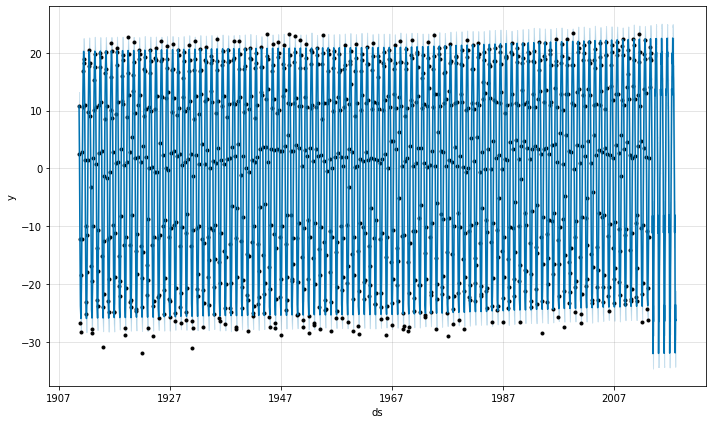

In [45]:
fig1 = m.plot(forecast)

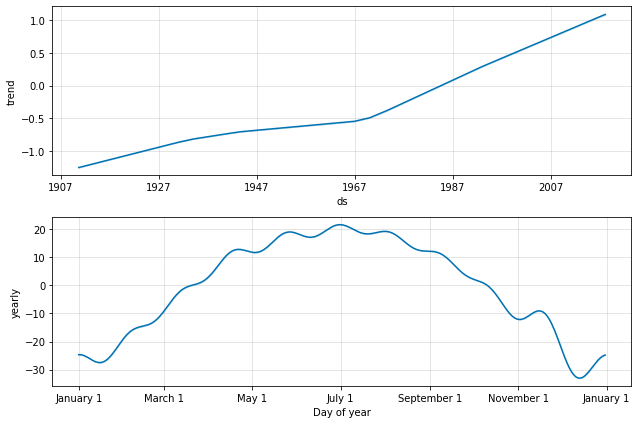

In [46]:
fig2 = m.plot_components(forecast)

In [47]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [48]:
plot_components_plotly(m, forecast)


#Conclusion

* Are there any variables or additional data sources you could use?

> If the Uncertainty could be provided for future dates then Uncertainty can be used as a Regressor for the Model

*   Which preprocessing did you perform and why?
> I tried to replace null. 4 hours is very small timeframe with limited compute resources to actually create classes, clean data, create pipelines and do ML.

*   Which methods/tools would you look into if given more time?
> Resource Side : Do the ML in AWS or Azure.
> Time wise
> Data : Do more data Cleaning. Train more Models like Linear regression , LSTM etc

*   Any results you came across worth mentioning/interpreting?
> The associated time frame was barely enough to go through  the Engineering and 
*  How satisfied and confident are you with the resulting model?   
> This analysis only focussed on a tiny part of the Dataset. With more time, Better results can be achieved.


